<div class="alert alert-block alert-warning">

# Machine Learning with Text in scikit-learn
<u>210 documentos difundidos por el Banco Mundial relacionados con inversiones en Filipinas: <br></u><br>
aprendizaje supervisado: clasificación<br>
aprendizaje no supervisado: clustering

<div class="alert alert-block alert-info">

## Tratatamiento de PDFs y estracción de información (no estructurada)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
print(os.getcwd())
mypath=os.getcwd()

C:\Users\IÑIGO\Documents\InfoNoEstructurada_ProcesamientoLenguajeNatural_TextMining\TRABAJO FIN DE MASTER


In [3]:
# Cambiar nuestro directorio de trabajo a aquel en el qué estén los documentos a clasificar
os.chdir('C:/Users/IÑIGO/Documents/WORLDBANK/TEST/PDFs')
mypath=os.getcwd()

In [4]:
# PASO 1
# crear 2 listas; una con el nombre y extensión de los documentos y otra con su ubicación 'virtual'
import timeit
start_time = timeit.default_timer()
import os
List_Documents=[]
ListDirDocuments=[]

for (root, directories, filenames) in os.walk(mypath):
    for f in filenames:
                
        List_Documents.append(os.path.join(f))
        List_Documents=list(filter(lambda x: (x.endswith('pdf')), List_Documents))
        
        ListDirDocuments.append(os.path.join(root,f).replace('\\','/'))
        ListDirDocuments=list(filter(lambda x: (x.endswith('pdf')), ListDirDocuments))
        
elapsed = timeit.default_timer() - start_time
print("Time elapsed is {:.2f} seconds".format(elapsed))

Time elapsed is 0.03 seconds


In [5]:
# PASO 2
# crear otra LISTA CON EL NUMERO DE PAGINAS DE CADA PDF

import timeit
start_time = timeit.default_timer()
from PyPDF2 import PdfFileReader

NumberOfPagesList=[]
for i in range(0,len(ListDirDocuments)):
    
    NumberOfPagesList.append(PdfFileReader(stream=ListDirDocuments[i]).getNumPages()) 
    
elapsed = timeit.default_timer() - start_time
print("Time elapsed is {:.2f} seconds".format(elapsed))
print("NumberOfPagesList tiene ({}) elementos".format(len(NumberOfPagesList)))

Time elapsed is 21.90 seconds
NumberOfPagesList tiene (210) elementos


In [7]:
# PASO 3
# Combinar toda la información extraida hasta ahora en una Matriz "pandas" --df1--

import pandas as pd
df1=pd.DataFrame({'Nombre_Documento':List_Documents,
                  'Ubicación':ListDirDocuments,
                'Número de Páginas':NumberOfPagesList})
df1=df1[['Nombre_Documento','Número de Páginas','Ubicación']]
df1.shape

(210, 3)

<div class="alert alert-block alert-info">
    EXTRACCIÓN DEL TEXTO DE LOS DOCUMENTOS

In [8]:
# PASO 4
# LISTA CON EL TEXTO DE TODAS LAS PAGINAS DE CADA PDF
# ================lA EJECUCIÓN DE ESTA CELDA SUELE TARDAR UNOS ***15-20 MINUTOS***========================
# ================lEE 210 PDFs y extrae el texto de once mil doscientos setenta y cuatro (11.274) páginas====================

import timeit
start_time = timeit.default_timer()

from PyPDF2 import PdfFileReader
TextExtractionList=[]

for i in range(0,len(ListDirDocuments)):
    
    read_pdf=PdfFileReader(ListDirDocuments[i])
    number_of_pages = read_pdf.getNumPages()
    for page_number in range(number_of_pages):
        page = read_pdf.getPage(page_number)
        page_content = page.extractText()
        
        TextExtractionList.append(page_content)
    
elapsed = (timeit.default_timer() - start_time)/60
print("Time elapsed is {:.1f} minutes".format(elapsed))

Time elapsed is 16.1 minutes


In [9]:
# PASO 5
# A continuación redimensionamos "TextExtractionList" de 11.274 filas a 210 filas
TEL = []
c = 0
for np in NumberOfPagesList:       
    LP = TextExtractionList[c:c+np]
    c+= np
    TEL.append(LP)

In [10]:
# PASO 6
# Modificamos TEL para que todos sus elementos sean una única cadena de texto
TELstr=[] #===========================
for i in range(len(TEL)):
    TELstr.append(" ".join(TEL[i]))

In [11]:
# PASO 7 
# Combinar toda la información extraida hasta ahora en una nueva Matriz "pandas" df2
df2=pd.DataFrame({'Documento':List_Documents,
                  'Num.Páginas':NumberOfPagesList,
                  'AllRawText':TELstr,
                  'Dir':ListDirDocuments})
df2.shape

(210, 4)

In [12]:
# PASO 8
# feature selection
# creamos una nueva Matriz añadiendo una columna nueva con el texto depurado de todos los caracteres que no sean letras
# a continuación procesamos los tokens resultantes extrayendo sus 'raíces' - "Stemming"

import timeit
start_time = timeit.default_timer()

from nltk.stem import SnowballStemmer
stemmer=SnowballStemmer("english")
from nltk.corpus import stopwords
WordsStoped=stopwords.words("english")

import re
df2['Texto+Limpio']=df2.AllRawText.apply\
(lambda x: " ".join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]'," ",x).split() if i not in WordsStoped]).lower())

df3=df2.drop('Dir',axis=1)

elapsed = (timeit.default_timer() - start_time)
print("Tiempo transcurrido: {:.0f} segundos".format(elapsed))

Tiempo transcurrido: 81 segundos


<div class="alert alert-block alert-info">

## Obtención de la matriz de características (X) y el vector de categorias (y)

In [ ]:
# PASO 9
# =======================================================================================================================
# A continuación asignamos a cada PDF su "categoria" desde (World_Bank_Documents_Classification_P.xlsm)
# En este Excel se encuentra la clasificación manual de los 210 documentos
# =======================================================================================================================

In [13]:
# 9a - IMPORTAMOS EL FICHERO
import os
os.chdir('C:/Users/IÑIGO/Documents/InfoNoEstructurada_ProcesamientoLenguajeNatural_TextMining/TRABAJO FIN DE MASTER')
import pandas as pd
worldbank=pd.read_excel('World_Bank_Documents_Classification_P.xlsm',
                        sheet_name='WBD_PHILIPPINES_CLASSIFICATION',
                        skiprows=7, 
                        usecols=[0,1,2,3,4,5,6,7,8,9,10])

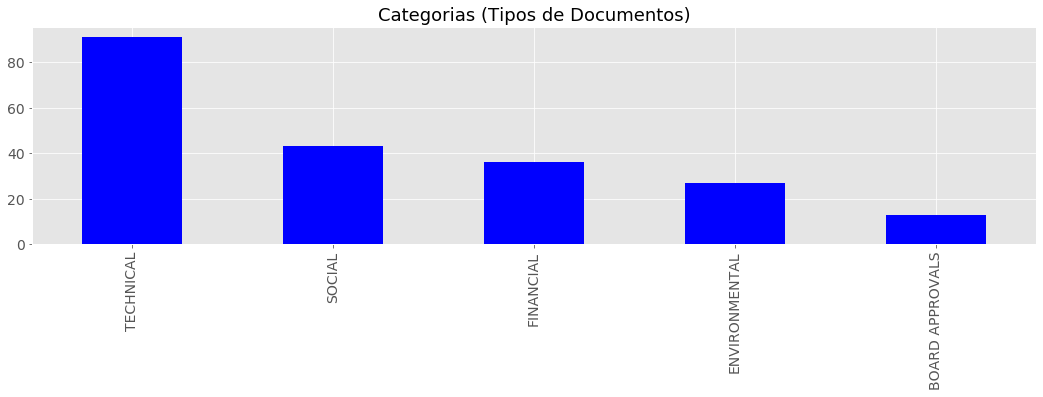

In [14]:
# 9b -VISUALIZACIÓN DE LAS 5 CATEGORIAS
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

grafica_types= worldbank.Type.value_counts()

ax=grafica_types.plot(kind='bar',
                      figsize=(18,4),
                      fontsize=14,
                      color="blue")

ax.set_title('Categorias (Tipos de Documentos)',fontsize=18, color="black");
ax.set_ylabel('',fontsize=16, color="brown");
ax.set_xlabel('',fontsize=18, color="brown");

In [15]:
# 9c - Fusionamos todo en una nueva matriz "pandas" para extraer vector de atributos (X) y vector de categorias (y)
MERGED=df3.join([worldbank.Type])
MERGED.shape
MERGED.isnull().sum()

(210, 5)

Documento       0
Num.Páginas     0
AllRawText      0
Texto+Limpio    0
Type            0
dtype: int64

In [16]:
display(MERGED.head())

,Documento,Num.Páginas,AllRawText,Texto+Limpio,Type
0,Appraisal__ISDS--08-28-2014.pdf,14,Page 1 of 14Public Disclosure CopyPublic Discl...,page public disclosur copypubl disclosur copyi...,TECHNICAL
1,Audited Financial Statements -CY2017.pdf,20,AUDITED FINANCIAL STATEMENTS\nPublic Disclosur...,audit financi statement public disclosur autho...,FINANCIAL
2,Audited Financial Statements -CY2017_Fd.pdf,20,AUDITED FINANCIAL STATEMENTS\nPublic Disclosur...,audit financi statement public disclosur autho...,FINANCIAL
3,Cebu-BRT-Audited Financial Statements-CY2016.pdf,20,AUDITED FINANCIAL STATEMENTS\nPublic Disclosur...,audit financi statement public disclosur autho...,FINANCIAL
4,Cebu-BRT-Audited Financial Statements-CY2016_b...,20,AUDITED FINANCIAL STATEMENTS\nPublic Disclosur...,audit financi statement public disclosur autho...,FINANCIAL


In [18]:
# 9d -Extraemos vector de atributos (X) y vector de categorias (y)
X = MERGED['Texto+Limpio'] # pandas Series con el TEXTO extraido de cada PDF
y = MERGED.Type # pandas Series con las CLASIFICACIONES (LABELs)
print(X.shape)
print(y.shape)

(210,)
(210,)


In [19]:
# 9e -Listado de las 5 categorias de (y) y su distribución
y.value_counts()
y.value_counts().sum()

TECHNICAL          91
SOCIAL             43
FINANCIAL          36
ENVIRONMENTAL      27
BOARD APPROVALS    13
Name: Type, dtype: int64

210

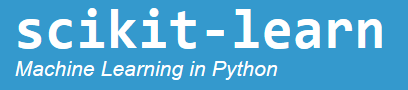

<div class="alert alert-block alert-success">


# APRENDIZAJE NO SUPERVISADO

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=2, max_df=0.85,stop_words='english')
XX = vectorizer.fit_transform(X)
from sklearn.cluster import MiniBatchKMeans
categorias = 5
kmeans = MiniBatchKMeans(n_clusters=categorias,
               init='k-means++',
               max_iter=100,
               n_init=1)
kmeans.fit(XX)
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
features = vectorizer.get_feature_names()

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=5, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

In [27]:
lista1=[]
n=10
for i in range(0,len(order_centroids)):
    for j in range(n):
        lista1.append(features[order_centroids[i][j]])

lista2 = [lista1[i * n:(i + 1) * n] for i in range((len(lista1) + n - 1) // n )]
import pandas as pd
dfcluster=pd.DataFrame(data={'Cluster 1':lista2[0],
                             'Cluster 2':lista2[1],
                             'Cluster 3':lista2[2],
                             'Cluster 4':lista2[3],
                             'Cluster 5':lista2[4]},index=range(1,n+1))
dfcluster

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
1,dotr,baselineactu,jun,environment,brt
2,wb,targetvalu,wastewat,area,oct
3,prior,irrig,actual,shall,reportcebu
4,icb,reportparticipatori,baselineactu,bank,baselineactu
5,procur,actual,targetvalu,impact,apr
6,consult,previous,custom,irrig,targetvalu
7,sbd,dec,mwci,land,bus
8,select,mar,maynilad,resettl,bankimplement
9,packag,bankimplement,previous,water,dec
10,afd,custom,dec,use,custom


<div class="alert alert-block alert-success">

# APRENDIZAJE SUPERVISADO

In [165]:
# PASO 10
# Ahora dividimos 'X' e 'y' en "training" y "testing" sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X,y,random_state=123,test_size=0.25, train_size=0.75)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(157,) (53,) (157,) (53,)


<div class="alert alert-block alert-info">

#### PASO 11<br>
### Transformamos texto en vectores numéricos
 

In [166]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(min_df=2,
                       max_df=0.85,
                       stop_words='english')
X_train_dtm = vect.fit_transform(X_train) ## *X_train_tokens*=vect.get_feature_names()
X_train_dtm
X_test_dtm = vect.transform(X_test)
X_test_dtm

<157x14623 sparse matrix of type '<class 'numpy.int64'>'
	with 142875 stored elements in Compressed Sparse Row format>

<53x14623 sparse matrix of type '<class 'numpy.int64'>'
	with 47436 stored elements in Compressed Sparse Row format>

<div class="alert alert-block alert-success">

#### PASO 12<br>
## Preparar y evaluar `Multinomial Naive Bayes`

In [167]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
from sklearn import metrics
round(metrics.accuracy_score(y_test, y_pred_class),4)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

0.8113

In [168]:
# Matriz de confusión========= conjunto de prueba ===53 documentos==========
metrics.confusion_matrix(y_test, y_pred_class)
metrics.confusion_matrix(y_test, y_pred_class).sum()

array([[ 1,  0,  0,  1,  0],
       [ 0,  4,  0,  1,  2],
       [ 0,  0,  5,  0,  2],
       [ 0,  0,  0,  8,  3],
       [ 0,  1,  0,  0, 25]], dtype=int64)

53

In [169]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_class))

                 precision    recall  f1-score   support

BOARD APPROVALS       1.00      0.50      0.67         2
  ENVIRONMENTAL       0.80      0.57      0.67         7
      FINANCIAL       1.00      0.71      0.83         7
         SOCIAL       0.80      0.73      0.76        11
      TECHNICAL       0.78      0.96      0.86        26

       accuracy                           0.81        53
      macro avg       0.88      0.69      0.76        53
   weighted avg       0.82      0.81      0.80        53



## CURVAS ROC

In [170]:
y_pred_class_l=y_pred_class.tolist()
y_pred_class_technical=[1 if x == 'TECHNICAL' else 0 for x in y_pred_class_l]
y_pred_class_social=[1 if x == 'SOCIAL' else 0 for x in y_pred_class_l]
y_pred_class_financial=[1 if x == 'FINANCIAL' else 0 for x in y_pred_class_l]
y_pred_class_environmental=[1 if x == 'ENVIRONMENTAL' else 0 for x in y_pred_class_l]
y_pred_class_BA=[1 if x == 'BOARD APPROVALS' else 0 for x in y_pred_class_l]

In [171]:
y_test_class_l=y_test.tolist()
y_test_technical=[1 if x == 'TECHNICAL' else 0 for x in y_test_class_l]
y_test_social=[1 if x == 'SOCIAL' else 0 for x in y_test_class_l]
y_test_financial=[1 if x == 'FINANCIAL' else 0 for x in y_test_class_l]
y_test_environmental=[1 if x == 'ENVIRONMENTAL' else 0 for x in y_test_class_l]
y_test_BA=[1 if x == 'BOARD APPROVALS' else 0 for x in y_test_class_l]

NameError: name 'a' is not defined

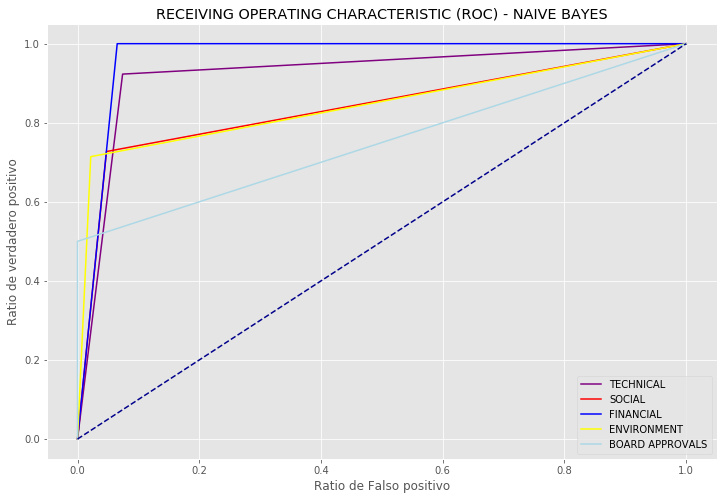

AUC Total:0.8656

Technical: 0.9245
Social: 0.8398
Financial: 0.9674
Environmental: 0.8463
Board Approvals: 0.7500


In [197]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr_T, tpr_T, threshold=roc_curve(y_test_technical,y_pred_class_technical)
fpr_S, tpr_S, threshold=roc_curve(y_test_social,y_pred_class_social)
fpr_F, tpr_F, threshold=roc_curve(y_test_financial,y_pred_class_financial)
fpr_E, tpr_E, threshold=roc_curve(y_test_environmental,y_pred_class_environmental)
fpr_BA, tpr_BA, threshold=roc_curve(y_test_BA,y_pred_class_BA)

def plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,Titulo):  
    plt.figure(figsize=(12, 8))
    plt.plot(fpr_T, tpr_T, color='purple', label='TECHNICAL')
    plt.plot(fpr_S, tpr_S, color='red', label='SOCIAL')
    plt.plot(fpr_F, tpr_F, color='blue', label='FINANCIAL')
    plt.plot(fpr_E, tpr_E, color='yellow', label='ENVIRONMENT')
    plt.plot(fpr_BA, tpr_BA, color='lightblue', label='BOARD APPROVALS')
    
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('Ratio de Falso positivo')
    plt.ylabel('Ratio de verdadero positivo')
    plt.title(Titulo)
    plt.legend()
    plt.show()
    a=roc_auc_score(y_test_technical,y_pred_class_technical)
    b=roc_auc_score(y_test_social,y_pred_class_social)
    c=roc_auc_score(y_test_financial,y_pred_class_financial)
    d=roc_auc_score(y_test_environmental,y_pred_class_environmental)
    e=roc_auc_score(y_test_BA,y_pred_class_BA)
    f=(a+b+c+d+e)/5
    print("AUC Total:{:.4f}\n\nTechnical: {:.4f}\nSocial: {:.4f}\nFinancial: {:.4f}\nEnvironmental: {:.4f}\nBoard Approvals: {:.4f}".format(f,a,b,c,d,e))
    
plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,'RECEIVING OPERATING CHARACTERISTIC (ROC) - NAIVE BAYES')

<div class="alert alert-block alert-success">

## Validación cruzada en `Multinomial Naive Bayes`

In [174]:
from sklearn.model_selection import cross_val_score
# Validación cruzada con 10 particiones distintas
nb = MultinomialNB()
scores = cross_val_score(nb, X_train_dtm, y_train, cv=10, scoring='accuracy')
print(scores)
print('\n', round(scores.mean(),4))

[1.         0.76470588 0.875      0.75       0.875      0.86666667
 0.6        0.66666667 1.         0.92857143]

 0.8327


<div class="alert alert-block alert-success">

#### PASO 13<br>
## <u>Comparar Multinomial Naive Bayes con **`K-NN`** y **`Logistic regression`**

<div class="alert alert-block alert-success">

### K-NEAREST NEIGHBORS (K-NN)

In [175]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(X,y,random_state=123,test_size=0.25,train_size=0.75)

In [176]:
X_train_dtm = vect.fit_transform(X_train)
X_train_dtm

<157x14623 sparse matrix of type '<class 'numpy.int64'>'
	with 142875 stored elements in Compressed Sparse Row format>

In [177]:
X_test_dtm = vect.transform(X_test)
X_test_dtm

<53x14623 sparse matrix of type '<class 'numpy.int64'>'
	with 47436 stored elements in Compressed Sparse Row format>

In [178]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_dtm, y_train)
y_pred_class = knn.predict(X_test_dtm) 
print(round(metrics.accuracy_score(y_test, y_pred_class),6))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

0.792453


In [179]:
y_pred_class_Knn=y_pred_class.tolist()
y_pred_class_technical=[1 if x == 'TECHNICAL' else 0 for x in y_pred_class_Knn]
y_pred_class_social=[1 if x == 'SOCIAL' else 0 for x in y_pred_class_Knn]
y_pred_class_financial=[1 if x == 'FINANCIAL' else 0 for x in y_pred_class_Knn]
y_pred_class_environmental=[1 if x == 'ENVIRONMENTAL' else 0 for x in y_pred_class_Knn]
y_pred_class_BA=[1 if x == 'BOARD APPROVALS' else 0 for x in y_pred_class_Knn]

In [180]:
y_test_class_Knn=y_test.tolist()
y_test_technical=[1 if x == 'TECHNICAL' else 0 for x in y_test_class_Knn]
y_test_social=[1 if x == 'SOCIAL' else 0 for x in y_test_class_Knn]
y_test_financial=[1 if x == 'FINANCIAL' else 0 for x in y_test_class_Knn]
y_test_environmental=[1 if x == 'ENVIRONMENTAL' else 0 for x in y_test_class_Knn]
y_test_BA=[1 if x == 'BOARD APPROVALS' else 0 for x in y_test_class_Knn]

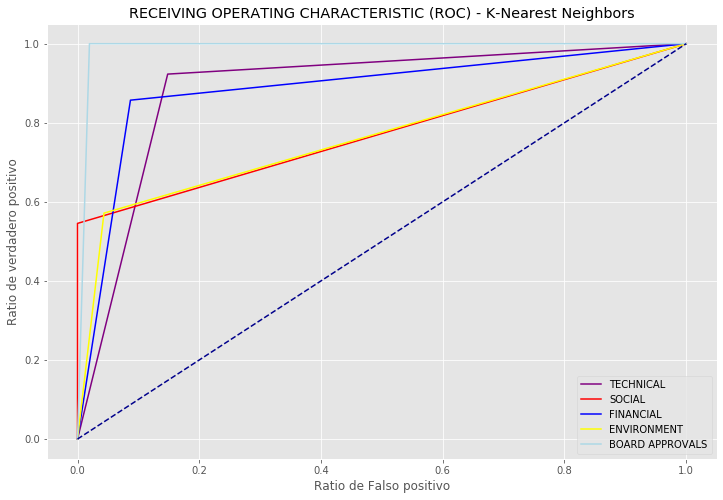

AUC:

Technical: 0.8875
Social: 0.7727
Financial: 0.8851
Environmental: 0.7640
Board Approvals: 0.9902
AUC Financial: 0.8851


In [181]:
fpr_T, tpr_T, threshold=roc_curve(y_test_technical,y_pred_class_technical)
fpr_S, tpr_S, threshold=roc_curve(y_test_social,y_pred_class_social)
fpr_F, tpr_F, threshold=roc_curve(y_test_financial,y_pred_class_financial)
fpr_E, tpr_E, threshold=roc_curve(y_test_environmental,y_pred_class_environmental)
fpr_BA, tpr_BA, threshold=roc_curve(y_test_BA,y_pred_class_BA)

plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,'RECEIVING OPERATING CHARACTERISTIC (ROC) - K-Nearest Neighbors')

## Validación cruzada en K-NN

In [182]:
# Primero buscamos encontrar el valor óptimo de K y visualizamos la precisión para cada valor del parametro K
from sklearn.model_selection import cross_val_score
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_dtm, y_train, cv=10, scoring='accuracy')
    k_scores.append(round(scores.mean(),2))
print(k_scores)

[0.86, 0.78, 0.84, 0.82, 0.8, 0.76, 0.72, 0.74, 0.68, 0.65, 0.61, 0.59, 0.6, 0.58, 0.57, 0.57, 0.58, 0.57, 0.57, 0.58, 0.54, 0.56, 0.58, 0.59, 0.59, 0.59, 0.58, 0.58, 0.58, 0.56]


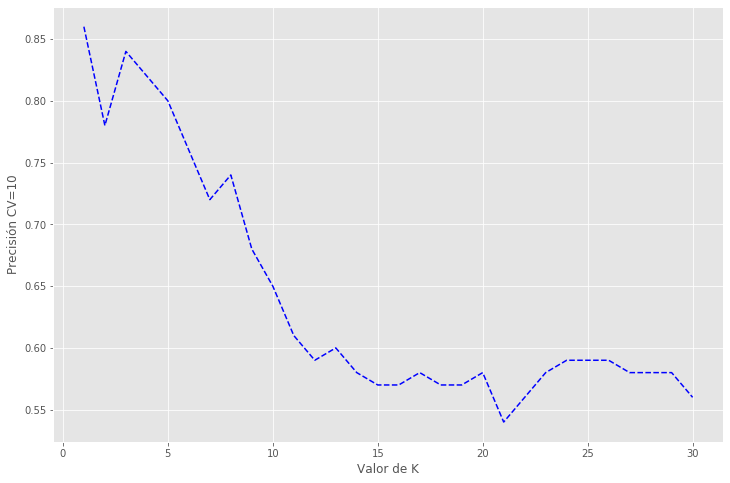

In [183]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12, 8))
plt.plot(k_range, k_scores,color="blue",linestyle='--');
plt.xlabel('Valor de K');
plt.ylabel('Precisión CV=10');

In [184]:
# # Validación cruzada con 10 particiones distintas
K=1 # parametro óptimo
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=K)
scores = cross_val_score(knn, X_train_dtm, y_train, cv=10, scoring='accuracy')
print(scores)
print('\n', round(scores.mean(),4))

[0.77777778 0.88235294 0.8125     0.75       1.         0.86666667
 0.86666667 0.8        0.86666667 0.92857143]

 0.8551


<div class="alert alert-block alert-success">

###  REGRESIÓN LOGÍSTICA

In [185]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver= 'lbfgs',multi_class='auto',max_iter=3000)
logreg.fit(X_train_dtm, y_train)
y_pred_class = logreg.predict(X_test_dtm)
round(metrics.accuracy_score(y_test, y_pred_class),6)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=3000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

0.849057

In [186]:
y_pred_class_RL=y_pred_class.tolist()
y_pred_class_technical=[1 if x == 'TECHNICAL' else 0 for x in y_pred_class_RL]
y_pred_class_social=[1 if x == 'SOCIAL' else 0 for x in y_pred_class_RL]
y_pred_class_financial=[1 if x == 'FINANCIAL' else 0 for x in y_pred_class_RL]
y_pred_class_environmental=[1 if x == 'ENVIRONMENTAL' else 0 for x in y_pred_class_RL]
y_pred_class_BA=[1 if x == 'BOARD APPROVALS' else 0 for x in y_pred_class_RL]

In [187]:
y_test_class_RL=y_test.tolist()
y_test_technical=[1 if x == 'TECHNICAL' else 0 for x in y_test_class_RL]
y_test_social=[1 if x == 'SOCIAL' else 0 for x in y_test_class_RL]
y_test_financial=[1 if x == 'FINANCIAL' else 0 for x in y_test_class_RL]
y_test_environmental=[1 if x == 'ENVIRONMENTAL' else 0 for x in y_test_class_RL]
y_test_BA=[1 if x == 'BOARD APPROVALS' else 0 for x in y_test_class_RL]

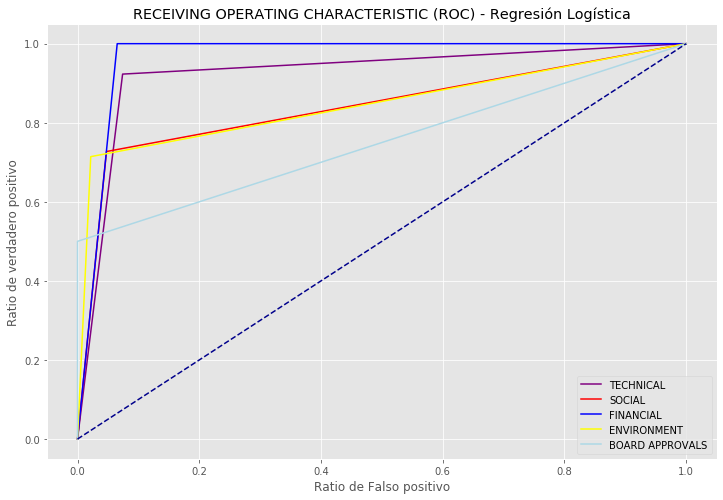

AUC:

Technical: 0.9245
Social: 0.8398
Financial: 0.9674
Environmental: 0.8463
Board Approvals: 0.7500
AUC Financial: 0.9674


In [188]:
fpr_T, tpr_T, threshold=roc_curve(y_test_technical,y_pred_class_technical)
fpr_S, tpr_S, threshold=roc_curve(y_test_social,y_pred_class_social)
fpr_F, tpr_F, threshold=roc_curve(y_test_financial,y_pred_class_financial)
fpr_E, tpr_E, threshold=roc_curve(y_test_environmental,y_pred_class_environmental)
fpr_BA, tpr_BA, threshold=roc_curve(y_test_BA,y_pred_class_BA)

plot_roc_curve(fpr_T, tpr_T,fpr_S, tpr_S,fpr_F,tpr_F,fpr_E, tpr_E,fpr_BA, tpr_BA,'RECEIVING OPERATING CHARACTERISTIC (ROC) - Regresión Logística')

## Validación cruzada en regresión logística

In [189]:
# 10 particiones distintas
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(round(cross_val_score(logreg, X_train_dtm, y_train, cv=10, scoring='accuracy').mean(),4))

0.8973
